## Capstone Project | EDA

#### Predict next-day EXCESS return (stock - beta_index*index - beta_sector*sector)
##### Optimize trading threshold for Sharpe (economic objective).
##### Includes EDA, PCA, robust feature engineering, and hedged backtest.


### Import Libraries/Packages

In [ ]:
# !pip install yfinance

In [1]:
import yfinance as yf

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve
)

### CONFIG — may set TARGET to be a list of multiple stocks in a future version

In [5]:
TARGET = "AAPL"     # e.g., "MSFT", "TSLA"
INDEX  = "^GSPC"    # or "SPY"
START  = "2014-01-01"
END    = None       # None => today
BETA_WINDOW = 60    # Lookback (trading days) for the rolling beta used to hedge the stock with the index/sector. May change to 120 or 252.
BETA_MINPER = 20    # Minimum observations required to compute the rolling beta
TEST_SIZE   = 0.20  # Fraction of the most recent data kept as a final test set.
VAL_FRAC    = 0.20  # Fraction of TRAIN used as validation slice

# Sector ETFs (SPDRs). Will auto-pick the sector most correlated with individual stocks.
SECTORS = ["XLK","XLF","XLE","XLY","XLP","XLI","XLB","XLV","XLU","XLRE","XLC"]

# Macro proxies / risk sentiment proxies
MACRO = {
    "VIX": "^VIX",   # Implied vol level
    "HYG": "HYG",    # High-yield credit
    "LQD": "LQD",    # Investment-grade credit
    "UUP": "UUP",    # USD index ETF proxy
    "IEF": "IEF",    # 7-10y Treasury
    "TLT": "TLT",    # 20+ year Treasury
    "TNX": "^TNX",   # 10y yield level (CBOE), in percentage points
}

ALL_TICKERS = [TARGET, INDEX] + SECTORS + list(MACRO.values())

### Helper functions

In [7]:
def normalize_yf(df, tickers):
    """
    Return a wide (Date x Ticker) price table from yfinance output.
    Handles both MultiIndex layouts:
      - fields-first:  ('Adj Close','AAPL')
      - tickers-first: ('AAPL','Adj Close')
    Falls back to 'Close' if 'Adj Close' is missing.
    """
    if isinstance(df.columns, pd.MultiIndex):
        lv0 = df.columns.get_level_values(0)
        lv1 = df.columns.get_level_values(1)

        # detect which level holds fields
        if ('Adj Close' in lv0) or ('Close' in lv0):
            field_level, ticker_level = 0, 1
        elif ('Adj Close' in lv1) or ('Close' in lv1):
            field_level, ticker_level = 1, 0
        else:
            raise KeyError("Could not find price fields in MultiIndex columns.")

        if 'Adj Close' in df.columns.get_level_values(field_level):
            prices = df.xs('Adj Close', axis=1, level=field_level)
        elif 'Close' in df.columns.get_level_values(field_level):
            prices = df.xs('Close', axis=1, level=field_level)
        else:
            raise KeyError("Neither 'Adj Close' nor 'Close' found at detected field level.")

        present = [t for t in tickers if t in prices.columns]
        if not present:
            raise KeyError("None of the requested tickers present after normalization.")
        prices = prices[present].copy()

    else:
        # Single ticker shape: plain OHLCV columns
        if 'Adj Close' in df.columns:
            s = df['Adj Close'].rename(tickers[0])
        elif 'Close' in df.columns:
            s = df['Close'].rename(tickers[0])
        else:
            raise KeyError("Single-ticker DataFrame lacks 'Adj Close'/'Close'.")
        prices = s.to_frame()

    # ensure numeric dtype
    prices = prices.apply(pd.to_numeric, errors='coerce')
    return prices

def rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0.0)
    down = (-delta).clip(lower=0.0)
    roll_up = up.rolling(window, min_periods=window).mean()
    roll_down = down.rolling(window, min_periods=window).mean()
    rs = roll_up / (roll_down + 1e-12)
    r = 100 - 100 / (1 + rs)
    return r.replace([np.inf, -np.inf], np.nan)

def bb_percent_b(series, window=20, n_std=2):
    ma = series.rolling(window, min_periods=window).mean()
    sd = series.rolling(window, min_periods=window).std()
    upper = ma + n_std * sd
    lower = ma - n_std * sd
    return (series - lower) / (upper - lower)

def realized_vol_abs(ret, w):
    return ret.abs().rolling(w, min_periods=w).mean()

def rolling_beta(stock_ret, mkt_ret, window=60, min_periods=20):
    """Rolling beta with expanding fallback to avoid early NaNs."""
    cov_w = stock_ret.rolling(window, min_periods=min_periods).cov(mkt_ret)
    var_w = mkt_ret.rolling(window, min_periods=min_periods).var()
    beta = cov_w / (var_w + 1e-12)
    # expanding fallback (no leakage; uses info up to each date)
    cov_e = stock_ret.expanding(min_periods=10).cov(mkt_ret)
    var_e = mkt_ret.expanding(min_periods=10).var()
    beta = beta.combine_first(cov_e / (var_e + 1e-12))
    return beta

def perf_stats(returns, trading_days=252):
    rets = returns.dropna()
    if len(rets) == 0:
        return {"CAGR": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}
    cum = (1 + rets).cumprod()
    total_return = cum.iloc[-1] - 1
    years = len(rets) / trading_days
    cagr = (1 + total_return) ** (1 / years) - 1 if years > 0 else np.nan
    sharpe = np.sqrt(trading_days) * rets.mean() / (rets.std() + 1e-12)
    peak = cum.cummax()
    drawdown = cum / peak - 1
    maxdd = drawdown.min()
    return {"CAGR": cagr, "Sharpe": sharpe, "MaxDD": maxdd}

### 1) Download & normalize prices

In [9]:
raw = yf.download(ALL_TICKERS, start=START, end=END, auto_adjust=False, progress=False)
prices = normalize_yf(raw, ALL_TICKERS).sort_index().dropna(how='all')

# Returns
rets = prices.pct_change()

# Extract series
px_s   = prices.get(TARGET)
px_mkt = prices.get(INDEX)
ret_s  = rets.get(TARGET)
ret_m  = rets.get(INDEX)

# Sector returns table (some ETFs may be missing depending on date range)
sectors_present = [t for t in SECTORS if t in prices.columns]
sector_rets = rets[sectors_present].add_prefix("ret_") if sectors_present else pd.DataFrame(index=prices.index)

# Macro series
vix  = prices.get(MACRO["VIX"])
dvix = vix.pct_change() if vix is not None else None
ret_hyg = rets.get("HYG")
ret_lqd = rets.get("LQD")
credit_spread = (ret_hyg - ret_lqd) if (ret_hyg is not None and ret_lqd is not None) else None
ret_uup = rets.get("UUP")
ret_tlt = rets.get("TLT")
ret_ief = rets.get("IEF")
tnx  = prices.get("^TNX")
d_tnx = tnx.pct_change() if tnx is not None else None

### 2) Choose best sector ETF (highest |corr| with stock returns)

In [11]:
if not sector_rets.empty:
    cors = {s: ret_s.corr(rets[s]) for s in sectors_present}
    best_sector = max(cors, key=lambda k: abs(cors[k]))
else:
    best_sector = None

print(f"Best sector ETF by correlation: {best_sector}")

Best sector ETF by correlation: XLK


### 3) Feature engineering (t features to predict t+1)

In [13]:
df = pd.DataFrame(index=prices.index)
df['px'] = px_s
df['ret_s'] = ret_s
df['ret_m'] = ret_m
df['ret_s_lag1'] = ret_s.shift(1)
df['ret_m_lag1'] = ret_m.shift(1)
df['rv5_s']  = realized_vol_abs(ret_s, 5)
df['rv22_s'] = realized_vol_abs(ret_s, 22)
df['rv5_m']  = realized_vol_abs(ret_m, 5)
df['rv22_m'] = realized_vol_abs(ret_m, 22)
df['ma10'] = px_s.rolling(10, min_periods=10).mean()
df['ma30'] = px_s.rolling(30, min_periods=30).mean()
df['ma_spread'] = df['ma10'] - df['ma30']
df['rsi14'] = rsi(px_s, 14)
df['bbp20'] = bb_percent_b(px_s, 20, 2)

if vix is not None:
    df['vix'] = vix
if dvix is not None:
    df['dvix'] = dvix

if credit_spread is not None:
    df['credit_spread'] = credit_spread
if ret_uup is not None:
    df['ret_uup_lag1'] = ret_uup.shift(1)
if ret_tlt is not None:
    df['ret_tlt_lag1'] = ret_tlt.shift(1)
if ret_ief is not None:
    df['ret_ief_lag1'] = ret_ief.shift(1)
if d_tnx is not None:
    df['d_tnx'] = d_tnx

# add lagged sector returns (all present sectors)
if not sector_rets.empty:
    for c in sector_rets.columns:
        df[c + "_lag1"] = sector_rets[c].shift(1)

### 4) Build hedged excess-return target (index + best sector)

In [15]:
df['ret_s_next'] = df['ret_s'].shift(-1)
df['ret_m_next'] = df['ret_m'].shift(-1)

beta_m = rolling_beta(df['ret_s'], df['ret_m'], window=BETA_WINDOW, min_periods=BETA_MINPER)

if best_sector is not None:
    ret_sector = rets[best_sector].rename(f"ret_{best_sector}")
    df['ret_sector'] = ret_sector
    df['ret_sector_next'] = ret_sector.shift(-1)
    beta_s = rolling_beta(df['ret_s'], df['ret_sector'], window=BETA_WINDOW, min_periods=BETA_MINPER)
    df['excess_ret_next'] = df['ret_s_next'] - (beta_m * df['ret_m_next'] + beta_s * df['ret_sector_next'])
else:
    df['excess_ret_next'] = df['ret_s_next'] - (beta_m * df['ret_m_next'])

df['y_excess_up'] = (df['excess_ret_next'] > 0).astype(int)

# Drop rows with NaNs created by rolling/shift
df = df.dropna().copy()

### 5) EDA quick pass

Shape after features & target: (1814, 38)

Missingness (top 10):
 px              0
ret_XLV_lag1    0
ret_XLK_lag1    0
ret_XLF_lag1    0
ret_XLE_lag1    0
ret_XLY_lag1    0
ret_XLP_lag1    0
ret_XLI_lag1    0
ret_XLB_lag1    0
ret_XLU_lag1    0

Selected summary stats:
                   count       mean        std        min        25%  \
ret_s            1814.0   0.001119   0.019863  -0.128647  -0.008142   
ret_m            1814.0   0.000552   0.012629  -0.119841  -0.004579   
rv22_s           1814.0   0.013809   0.006405   0.005652   0.009595   
rv22_m           1814.0   0.008227   0.005606   0.002606   0.005095   
rsi14            1814.0  55.530774  17.526501   3.179820  42.742529   
ma_spread        1814.0   1.012783   5.088139 -18.306522  -2.222083   
bbp20            1814.0   0.587819   0.326612  -0.299180   0.318288   
excess_ret_next  1814.0  -0.000565   0.019718  -0.124504  -0.010848   

                       50%        75%        max  
ret_s             0.001261   0.011539

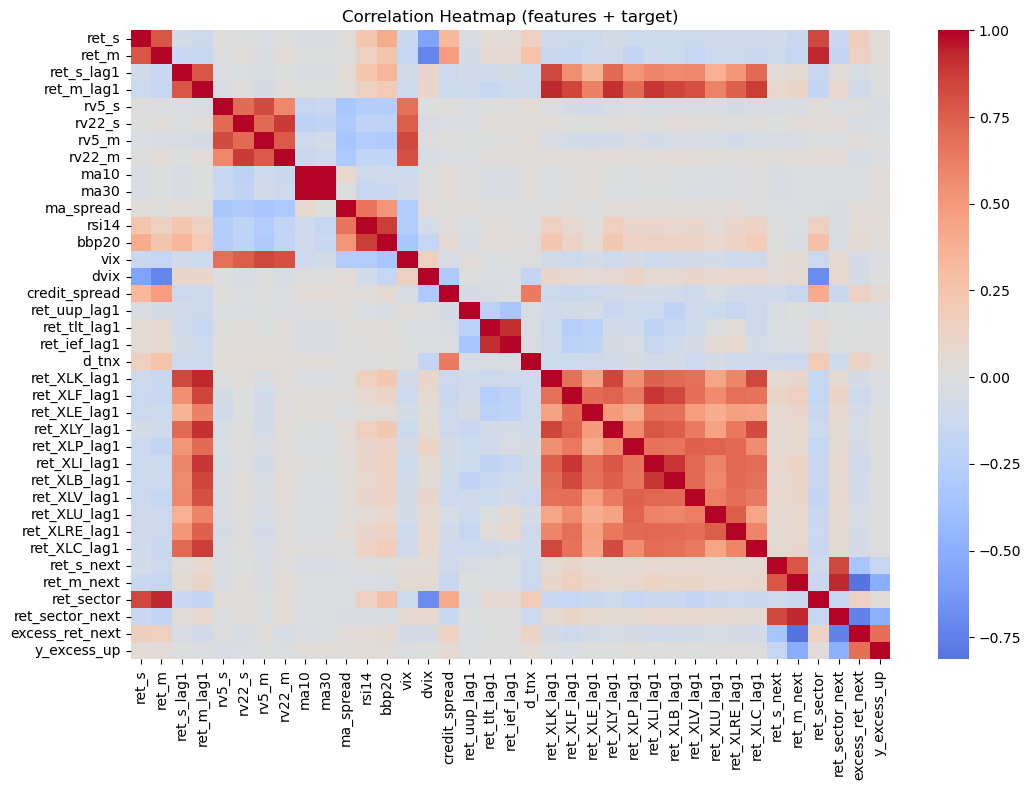

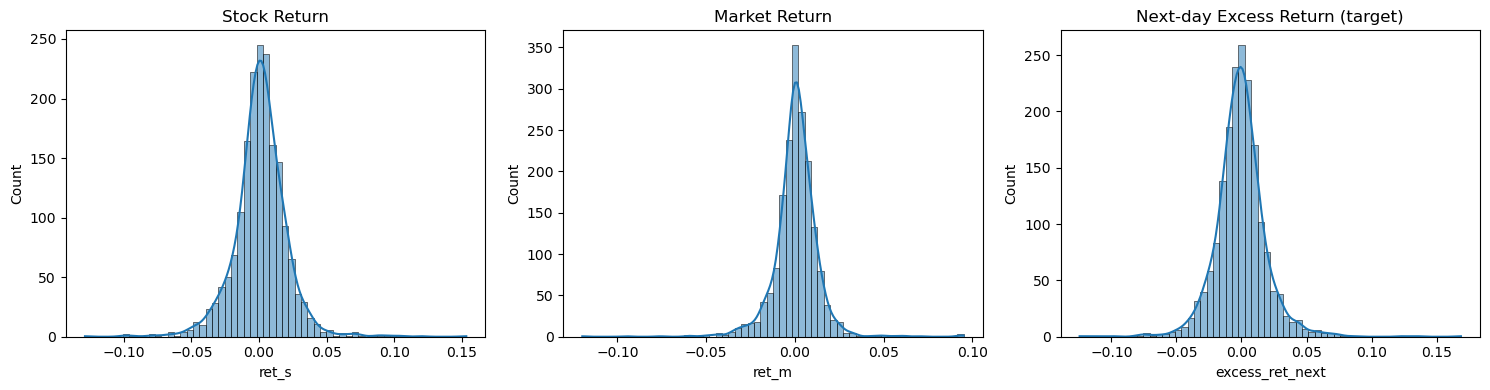

In [17]:
print("Shape after features & target:", df.shape)
print("\nMissingness (top 10):\n", df.isna().sum().sort_values(ascending=False).head(10).to_string())
print("\nSelected summary stats:\n", df[['ret_s','ret_m','rv22_s','rv22_m','rsi14','ma_spread','bbp20','excess_ret_next']].describe().T)

corr = df.drop(columns=['px']).corr(numeric_only=True)
corr.index.name = None; corr.columns.name=None
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (features + target)")
plt.xlabel(""); plt.ylabel("")
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.histplot(df['ret_s'], bins=60, kde=True, ax=axes[0]); axes[0].set_title("Stock Return")
sns.histplot(df['ret_m'], bins=60, kde=True, ax=axes[1]); axes[1].set_title("Market Return")
sns.histplot(df['excess_ret_next'], bins=60, kde=True, ax=axes[2]); axes[2].set_title("Next-day Excess Return (target)")
plt.tight_layout(); plt.show()

### 6) PCA (exploratory)


PCA explained variance: [0.3000152  0.14785692] Total: 0.447872126924413


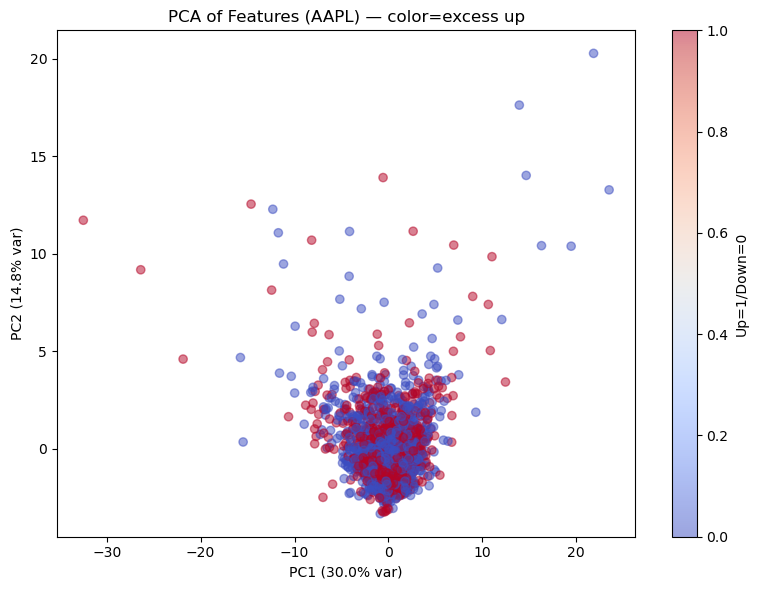

In [19]:
drop_cols = ['px','ret_s_next','ret_m_next','excess_ret_next','y_excess_up','ret_sector','ret_sector_next'] if 'ret_sector' in df.columns else \
            ['px','ret_s_next','ret_m_next','excess_ret_next','y_excess_up']
feature_cols = [c for c in df.columns if c not in drop_cols]

X_all = df[feature_cols].values
y_all = df['y_excess_up'].values

sc_all = StandardScaler()
X_all_sc = sc_all.fit_transform(X_all)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_sc)
print("\nPCA explained variance:", pca.explained_variance_ratio_, 
      "Total:", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_all, cmap="coolwarm", alpha=0.5)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title(f"PCA of Features ({TARGET}) — color=excess up")
plt.colorbar(sc, label="Up=1/Down=0")
plt.tight_layout(); plt.show()

### 7) Time-ordered split, scale, train logistic; tune threshold for Sharpe

In [21]:
X = df[feature_cols].values
y = df['y_excess_up'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)
train_idx = df.index[:len(X_train)]
test_idx  = df.index[len(X_train):]

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# Validation slice from the tail of TRAIN
split_idx = int(len(X_train_sc) * (1 - VAL_FRAC))
X_tr, X_val = X_train_sc[:split_idx], X_train_sc[split_idx:]
y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
val_idx = train_idx[split_idx:]

logit = LogisticRegression(class_weight='balanced', max_iter=1000)
logit.fit(X_tr, y_tr)

val_proba = logit.predict_proba(X_val)[:,1]
test_proba = logit.predict_proba(X_test_sc)[:,1]

# Build validation hedged excess returns aligned to val_idx
val_excess = df.loc[val_idx, 'excess_ret_next']

def sharpe_for(th, band=0.00):
    """Sharpe of validation strategy at threshold 'th' with confidence band."""
    pos = np.where(val_proba >= th + band, 1, np.where(val_proba <= th - band, -1, 0))
    r = pos * val_excess
    r = pd.Series(r, index=val_idx).dropna()
    if r.std() == 0 or len(r) < 10:
        return -np.inf
    return np.sqrt(252) * r.mean() / r.std()

thr_grid = np.linspace(0.35, 0.65, 31)
band_grid = [0.00, 0.02, 0.05]
best_tuple, best_score = None, -np.inf
for th in thr_grid:
    for band in band_grid:
        s = sharpe_for(th, band)
        if s > best_score:
            best_score = s
            best_tuple = (th, band)

best_thr, best_band = best_tuple
print(f"\n[Validation] Best Sharpe: {best_score:.3f} at threshold={best_thr:.3f}, band={best_band:.2f}")


[Validation] Best Sharpe: 2.536 at threshold=0.640, band=0.00


### 8) Test evaluation — classification metrics + hedged backtest


=== Classification (excess up) on TEST ===
ROC-AUC: 0.5370753683185194
PR-AUC : 0.5126940689965345

Classification Report:
               precision    recall  f1-score   support

           0      0.560     0.738     0.637       191
           1      0.550     0.355     0.431       172

    accuracy                          0.556       363
   macro avg      0.555     0.546     0.534       363
weighted avg      0.555     0.556     0.539       363

Confusion Matrix:
 [[141  50]
 [111  61]]

=== TEST Performance ===
Hedged Strategy (excess) | CAGR: 0.3579  Sharpe: 1.258  MaxDD: -0.249
           Buy&Hold AAPL | CAGR: 0.2392  Sharpe: 0.856  MaxDD: -0.334
          Buy&Hold Index | CAGR: 0.1616  Sharpe: 0.947  MaxDD: -0.189


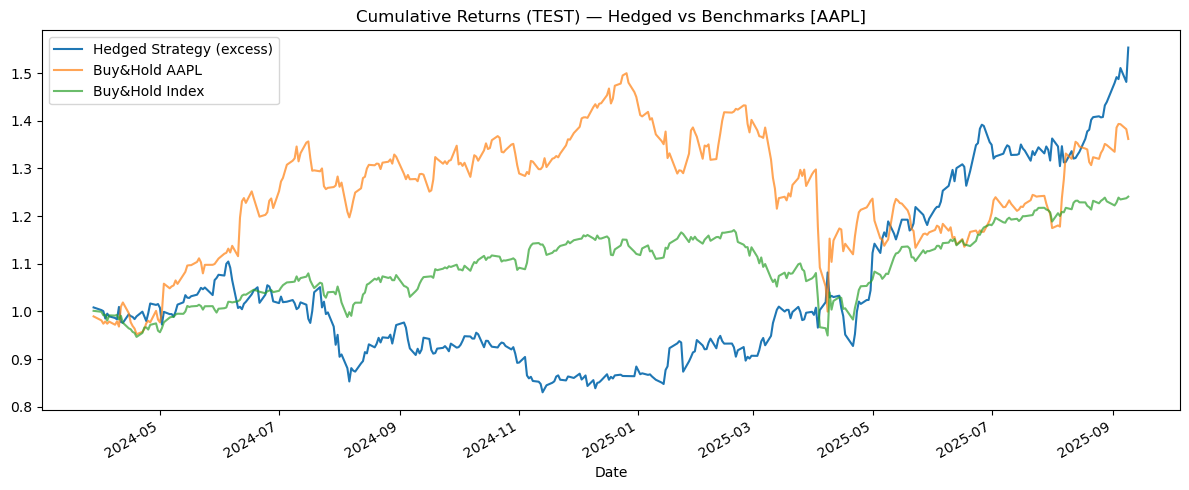

In [23]:
print("\n=== Classification (excess up) on TEST ===")
print("ROC-AUC:", roc_auc_score(y_test, test_proba))
print("PR-AUC :", average_precision_score(y_test, test_proba))

y_pred = (test_proba >= best_thr).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Construct TEST positions with confidence band
pos_test = np.where(test_proba >= best_thr + best_band, 1,
             np.where(test_proba <= best_thr - best_band, -1, 0))
pos_test = pd.Series(pos_test, index=test_idx)

# TEST hedged excess return series
test_excess = df.loc[test_idx, 'excess_ret_next']
strat_ret = (pos_test * test_excess).dropna()

# Benchmarks: unhedged directional on raw stock, and buy&hold stock / index
bh_stock = df.loc[test_idx, 'ret_s'].dropna()
bh_index = df.loc[test_idx, 'ret_m'].dropna()

# Performance
def print_perf(name, r):
    p = perf_stats(r)
    print(f"{name:>24s} | CAGR: {p['CAGR']:.4f}  Sharpe: {p['Sharpe']:.3f}  MaxDD: {p['MaxDD']:.3f}")

print("\n=== TEST Performance ===")
print_perf("Hedged Strategy (excess)", strat_ret)
print_perf(f"Buy&Hold {TARGET}", bh_stock)
print_perf("Buy&Hold Index", bh_index)

# Plot cumulative returns
plt.figure(figsize=(12,5))
(1 + strat_ret).cumprod().plot(label="Hedged Strategy (excess)")
(1 + bh_stock).cumprod().plot(label=f"Buy&Hold {TARGET}", alpha=0.7)
(1 + bh_index).cumprod().plot(label="Buy&Hold Index", alpha=0.7)
plt.legend()
plt.title(f"Cumulative Returns (TEST) — Hedged vs Benchmarks [{TARGET}]")
plt.tight_layout(); plt.show()

### Potential Next Steps

In [ ]:
# - Try more lags (t-2..t-5), volume surprises, range-based RV (Parkinson/Garman-Klass).
# - Add macro calendars (CPI/FOMC/Payroll) as known-at-t dummies.
# - Use walk-forward (retrain rolling) for more realistic evaluation.
# - Optimize threshold/band jointly with a small grid; include transaction costs.

Best sector ETF by correlation: XLK
Shape after features & target: (1811, 38)

Missingness (top 10):
 px              0
ret_XLV_lag1    0
ret_XLK_lag1    0
ret_XLF_lag1    0
ret_XLE_lag1    0
ret_XLY_lag1    0
ret_XLP_lag1    0
ret_XLI_lag1    0
ret_XLB_lag1    0
ret_XLU_lag1    0

Selected summary stats:
                   count       mean        std        min        25%  \
ret_s            1811.0   0.001133   0.019875  -0.128647  -0.008136   
ret_m            1811.0   0.000552   0.012639  -0.119841  -0.004587   
rv22_s           1811.0   0.013813   0.006410   0.005652   0.009592   
rv22_m           1811.0   0.008232   0.005609   0.002606   0.005099   
rsi14            1811.0  55.522413  17.539221   3.179825  42.728715   
ma_spread        1811.0   0.999704   5.082182 -18.306527  -2.232091   
bbp20            1811.0   0.587409   0.326669  -0.299179   0.317407   
excess_ret_next  1811.0  -0.000520   0.019694  -0.124503  -0.010826   

                       50%        75%        max  
r

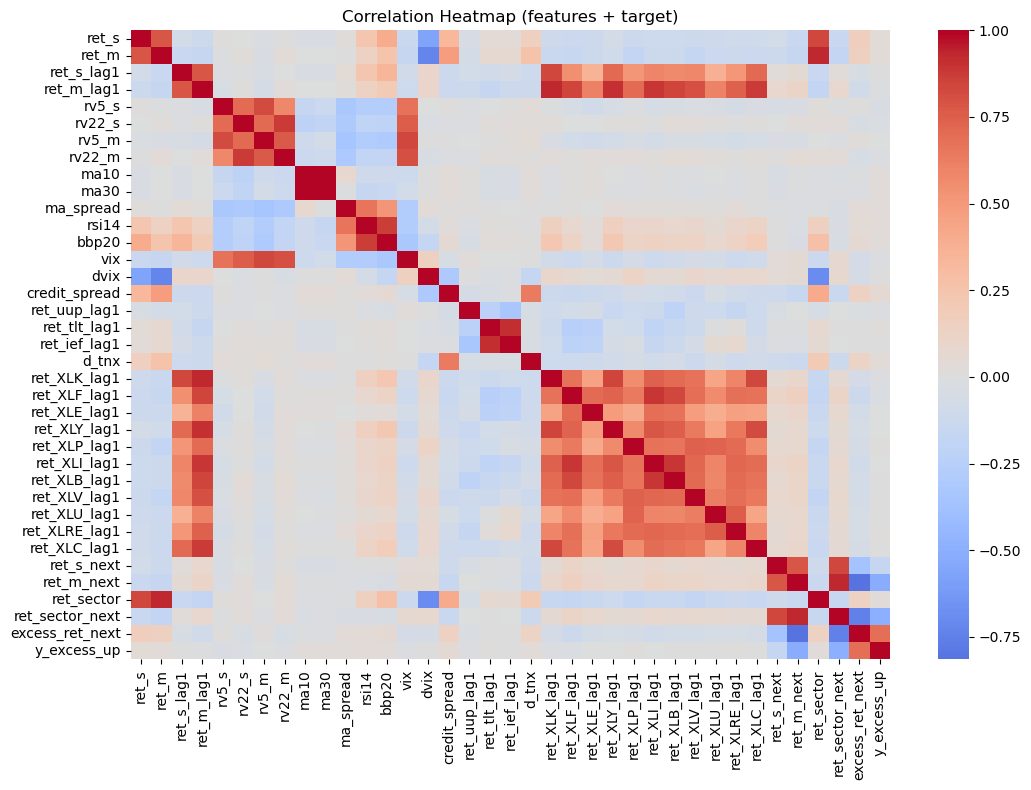

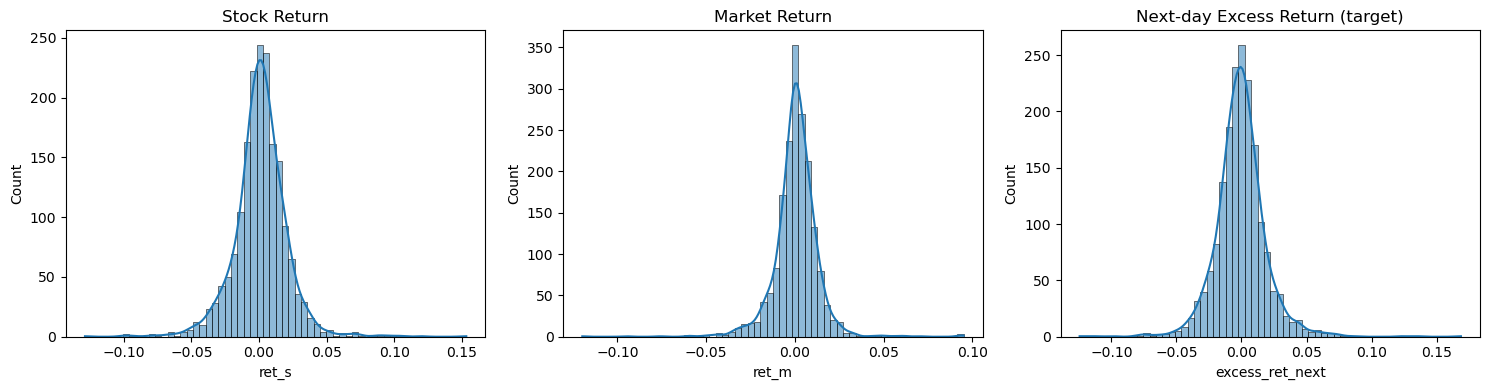


PCA explained variance: [0.30007552 0.14780918] Total: 0.4478846959382997


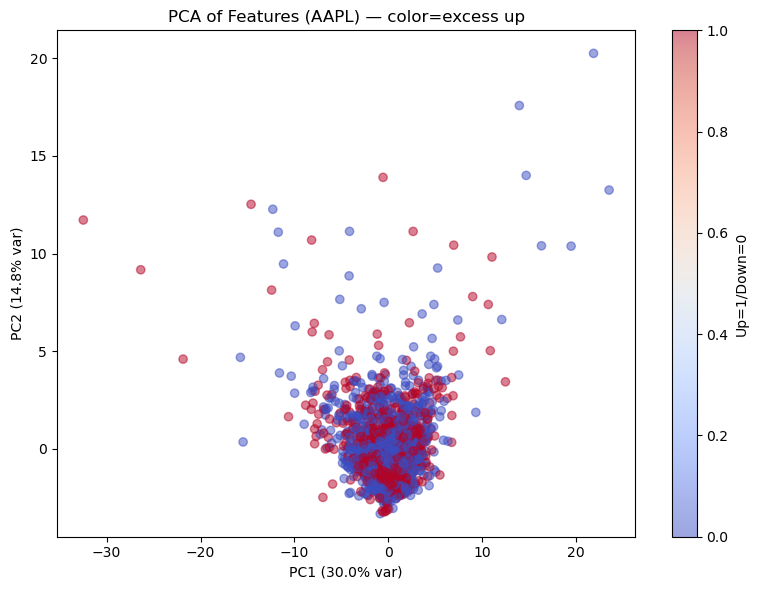


[Validation] Best Sharpe: 2.561 at threshold=0.640, band=0.00

=== Classification (excess up) on TEST ===
ROC-AUC: 0.5394280498935199
PR-AUC : 0.516382637296673

Classification Report:
               precision    recall  f1-score   support

           0      0.557     0.742     0.637       190
           1      0.555     0.353     0.431       173

    accuracy                          0.556       363
   macro avg      0.556     0.547     0.534       363
weighted avg      0.556     0.556     0.539       363

Confusion Matrix:
 [[141  49]
 [112  61]]

=== TEST Performance ===
Hedged Strategy (excess) | CAGR: 0.3191  Sharpe: 1.163  MaxDD: -0.249
           Buy&Hold AAPL | CAGR: 0.2642  Sharpe: 0.922  MaxDD: -0.334
          Buy&Hold Index | CAGR: 0.1625  Sharpe: 0.951  MaxDD: -0.189


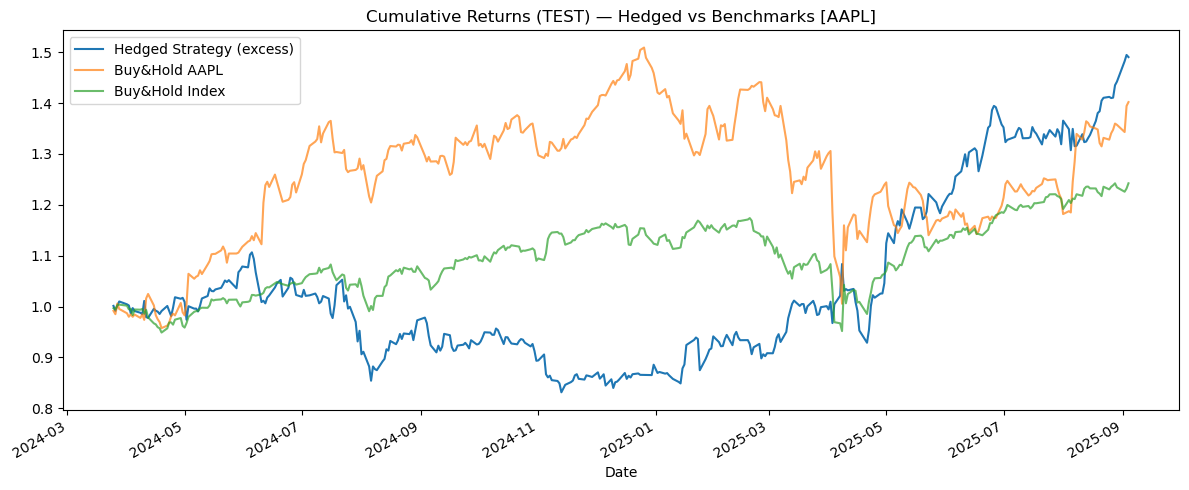

In [6]:
# ============================================================
# CAPSTONE (Clean) — Single-stock next-day direction (hedged)
# ============================================================
# Predict next-day EXCESS return (stock - beta_index*index - beta_sector*sector)
# Optimize trading threshold for Sharpe (economic objective).
# Includes EDA, PCA, robust feature engineering, and hedged backtest.
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve
)

# -------------------------------------------------------------------
# CONFIG — change TARGET to the single stock you care about
# -------------------------------------------------------------------
TARGET = "AAPL"    # e.g., "MSFT", "TSLA"
INDEX  = "^GSPC"   # or "SPY"
START  = "2014-01-01"
END    = None      # None => today
BETA_WINDOW = 60
BETA_MINPER = 20
TEST_SIZE   = 0.20
VAL_FRAC    = 0.20   # fraction of TRAIN used as validation slice

# Sector ETFs (SPDRs). We'll auto-pick the sector most correlated with the stock.
SECTORS = ["XLK","XLF","XLE","XLY","XLP","XLI","XLB","XLV","XLU","XLRE","XLC"]

# Macro proxies / risk sentiment proxies
MACRO = {
    "VIX": "^VIX",   # implied vol level
    "HYG": "HYG",    # high-yield credit
    "LQD": "LQD",    # investment-grade credit
    "UUP": "UUP",    # USD index ETF proxy
    "IEF": "IEF",    # 7-10y Treasury
    "TLT": "TLT",    # 20+ year Treasury
    "TNX": "^TNX",   # 10y yield level (CBOE), in percentage points
}

ALL_TICKERS = [TARGET, INDEX] + SECTORS + list(MACRO.values())

# -------------------------------------------------------------------
# Helpers
# -------------------------------------------------------------------
try:
    import yfinance as yf
except ImportError as e:
    raise ImportError("yfinance not installed. In a new cell: !pip install yfinance") from e

def normalize_yf(df, tickers):
    """
    Return a wide (Date x Ticker) price table from yfinance output.
    Handles both MultiIndex layouts:
      - fields-first:  ('Adj Close','AAPL')
      - tickers-first: ('AAPL','Adj Close')
    Falls back to 'Close' if 'Adj Close' is missing.
    """
    if isinstance(df.columns, pd.MultiIndex):
        lv0 = df.columns.get_level_values(0)
        lv1 = df.columns.get_level_values(1)

        # detect which level holds fields
        if ('Adj Close' in lv0) or ('Close' in lv0):
            field_level, ticker_level = 0, 1
        elif ('Adj Close' in lv1) or ('Close' in lv1):
            field_level, ticker_level = 1, 0
        else:
            raise KeyError("Could not find price fields in MultiIndex columns.")

        if 'Adj Close' in df.columns.get_level_values(field_level):
            prices = df.xs('Adj Close', axis=1, level=field_level)
        elif 'Close' in df.columns.get_level_values(field_level):
            prices = df.xs('Close', axis=1, level=field_level)
        else:
            raise KeyError("Neither 'Adj Close' nor 'Close' found at detected field level.")

        present = [t for t in tickers if t in prices.columns]
        if not present:
            raise KeyError("None of the requested tickers present after normalization.")
        prices = prices[present].copy()

    else:
        # Single ticker shape: plain OHLCV columns
        if 'Adj Close' in df.columns:
            s = df['Adj Close'].rename(tickers[0])
        elif 'Close' in df.columns:
            s = df['Close'].rename(tickers[0])
        else:
            raise KeyError("Single-ticker DataFrame lacks 'Adj Close'/'Close'.")
        prices = s.to_frame()

    # ensure numeric dtype
    prices = prices.apply(pd.to_numeric, errors='coerce')
    return prices

def rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0.0)
    down = (-delta).clip(lower=0.0)
    roll_up = up.rolling(window, min_periods=window).mean()
    roll_down = down.rolling(window, min_periods=window).mean()
    rs = roll_up / (roll_down + 1e-12)
    r = 100 - 100 / (1 + rs)
    return r.replace([np.inf, -np.inf], np.nan)

def bb_percent_b(series, window=20, n_std=2):
    ma = series.rolling(window, min_periods=window).mean()
    sd = series.rolling(window, min_periods=window).std()
    upper = ma + n_std * sd
    lower = ma - n_std * sd
    return (series - lower) / (upper - lower)

def realized_vol_abs(ret, w):
    return ret.abs().rolling(w, min_periods=w).mean()

def rolling_beta(stock_ret, mkt_ret, window=60, min_periods=20):
    """Rolling beta with expanding fallback to avoid early NaNs."""
    cov_w = stock_ret.rolling(window, min_periods=min_periods).cov(mkt_ret)
    var_w = mkt_ret.rolling(window, min_periods=min_periods).var()
    beta = cov_w / (var_w + 1e-12)
    # expanding fallback (no leakage; uses info up to each date)
    cov_e = stock_ret.expanding(min_periods=10).cov(mkt_ret)
    var_e = mkt_ret.expanding(min_periods=10).var()
    beta = beta.combine_first(cov_e / (var_e + 1e-12))
    return beta

def perf_stats(returns, trading_days=252):
    rets = returns.dropna()
    if len(rets) == 0:
        return {"CAGR": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}
    cum = (1 + rets).cumprod()
    total_return = cum.iloc[-1] - 1
    years = len(rets) / trading_days
    cagr = (1 + total_return) ** (1 / years) - 1 if years > 0 else np.nan
    sharpe = np.sqrt(trading_days) * rets.mean() / (rets.std() + 1e-12)
    peak = cum.cummax()
    drawdown = cum / peak - 1
    maxdd = drawdown.min()
    return {"CAGR": cagr, "Sharpe": sharpe, "MaxDD": maxdd}

# -------------------------------------------------------------------
# 1) Download & normalize prices
# -------------------------------------------------------------------
raw = yf.download(ALL_TICKERS, start=START, end=END, auto_adjust=False, progress=False)
prices = normalize_yf(raw, ALL_TICKERS).sort_index().dropna(how='all')

# Returns
rets = prices.pct_change()

# Extract series
px_s   = prices.get(TARGET)
px_mkt = prices.get(INDEX)
ret_s  = rets.get(TARGET)
ret_m  = rets.get(INDEX)

# Sector returns table (some ETFs may be missing depending on date range)
sectors_present = [t for t in SECTORS if t in prices.columns]
sector_rets = rets[sectors_present].add_prefix("ret_") if sectors_present else pd.DataFrame(index=prices.index)

# Macro series
vix  = prices.get(MACRO["VIX"])
dvix = vix.pct_change() if vix is not None else None
ret_hyg = rets.get("HYG")
ret_lqd = rets.get("LQD")
credit_spread = (ret_hyg - ret_lqd) if (ret_hyg is not None and ret_lqd is not None) else None
ret_uup = rets.get("UUP")
ret_tlt = rets.get("TLT")
ret_ief = rets.get("IEF")
tnx  = prices.get("^TNX")
d_tnx = tnx.pct_change() if tnx is not None else None

# -------------------------------------------------------------------
# 2) Choose best sector ETF (highest |corr| with stock returns)
# -------------------------------------------------------------------
if not sector_rets.empty:
    cors = {s: ret_s.corr(rets[s]) for s in sectors_present}
    best_sector = max(cors, key=lambda k: abs(cors[k]))
else:
    best_sector = None

print(f"Best sector ETF by correlation: {best_sector}")

# -------------------------------------------------------------------
# 3) Feature engineering (t features to predict t+1)
# -------------------------------------------------------------------
df = pd.DataFrame(index=prices.index)
df['px'] = px_s
df['ret_s'] = ret_s
df['ret_m'] = ret_m
df['ret_s_lag1'] = ret_s.shift(1)
df['ret_m_lag1'] = ret_m.shift(1)
df['rv5_s']  = realized_vol_abs(ret_s, 5)
df['rv22_s'] = realized_vol_abs(ret_s, 22)
df['rv5_m']  = realized_vol_abs(ret_m, 5)
df['rv22_m'] = realized_vol_abs(ret_m, 22)
df['ma10'] = px_s.rolling(10, min_periods=10).mean()
df['ma30'] = px_s.rolling(30, min_periods=30).mean()
df['ma_spread'] = df['ma10'] - df['ma30']
df['rsi14'] = rsi(px_s, 14)
df['bbp20'] = bb_percent_b(px_s, 20, 2)

if vix is not None:
    df['vix'] = vix
if dvix is not None:
    df['dvix'] = dvix

if credit_spread is not None:
    df['credit_spread'] = credit_spread
if ret_uup is not None:
    df['ret_uup_lag1'] = ret_uup.shift(1)
if ret_tlt is not None:
    df['ret_tlt_lag1'] = ret_tlt.shift(1)
if ret_ief is not None:
    df['ret_ief_lag1'] = ret_ief.shift(1)
if d_tnx is not None:
    df['d_tnx'] = d_tnx

# add lagged sector returns (all present sectors)
if not sector_rets.empty:
    for c in sector_rets.columns:
        df[c + "_lag1"] = sector_rets[c].shift(1)

# -------------------------------------------------------------------
# 4) Build hedged excess-return target (index + best sector)
# -------------------------------------------------------------------
df['ret_s_next'] = df['ret_s'].shift(-1)
df['ret_m_next'] = df['ret_m'].shift(-1)

beta_m = rolling_beta(df['ret_s'], df['ret_m'], window=BETA_WINDOW, min_periods=BETA_MINPER)

if best_sector is not None:
    ret_sector = rets[best_sector].rename(f"ret_{best_sector}")
    df['ret_sector'] = ret_sector
    df['ret_sector_next'] = ret_sector.shift(-1)
    beta_s = rolling_beta(df['ret_s'], df['ret_sector'], window=BETA_WINDOW, min_periods=BETA_MINPER)
    df['excess_ret_next'] = df['ret_s_next'] - (beta_m * df['ret_m_next'] + beta_s * df['ret_sector_next'])
else:
    df['excess_ret_next'] = df['ret_s_next'] - (beta_m * df['ret_m_next'])

df['y_excess_up'] = (df['excess_ret_next'] > 0).astype(int)

# Drop rows with NaNs created by rolling/shift
df = df.dropna().copy()

# -------------------------------------------------------------------
# 5) EDA quick pass
# -------------------------------------------------------------------
print("Shape after features & target:", df.shape)
print("\nMissingness (top 10):\n", df.isna().sum().sort_values(ascending=False).head(10).to_string())
print("\nSelected summary stats:\n", df[['ret_s','ret_m','rv22_s','rv22_m','rsi14','ma_spread','bbp20','excess_ret_next']].describe().T)

corr = df.drop(columns=['px']).corr(numeric_only=True)
corr.index.name = None; corr.columns.name=None
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (features + target)")
plt.xlabel(""); plt.ylabel("")
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.histplot(df['ret_s'], bins=60, kde=True, ax=axes[0]); axes[0].set_title("Stock Return")
sns.histplot(df['ret_m'], bins=60, kde=True, ax=axes[1]); axes[1].set_title("Market Return")
sns.histplot(df['excess_ret_next'], bins=60, kde=True, ax=axes[2]); axes[2].set_title("Next-day Excess Return (target)")
plt.tight_layout(); plt.show()

# -------------------------------------------------------------------
# 6) PCA (exploratory)
# -------------------------------------------------------------------
drop_cols = ['px','ret_s_next','ret_m_next','excess_ret_next','y_excess_up','ret_sector','ret_sector_next'] if 'ret_sector' in df.columns else \
            ['px','ret_s_next','ret_m_next','excess_ret_next','y_excess_up']
feature_cols = [c for c in df.columns if c not in drop_cols]

X_all = df[feature_cols].values
y_all = df['y_excess_up'].values

sc_all = StandardScaler()
X_all_sc = sc_all.fit_transform(X_all)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_sc)
print("\nPCA explained variance:", pca.explained_variance_ratio_, 
      "Total:", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_all, cmap="coolwarm", alpha=0.5)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title(f"PCA of Features ({TARGET}) — color=excess up")
plt.colorbar(sc, label="Up=1/Down=0")
plt.tight_layout(); plt.show()

# -------------------------------------------------------------------
# 7) Time-ordered split, scale, train logistic; tune threshold for Sharpe
# -------------------------------------------------------------------
X = df[feature_cols].values
y = df['y_excess_up'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)
train_idx = df.index[:len(X_train)]
test_idx  = df.index[len(X_train):]

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# Validation slice from the tail of TRAIN
split_idx = int(len(X_train_sc) * (1 - VAL_FRAC))
X_tr, X_val = X_train_sc[:split_idx], X_train_sc[split_idx:]
y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
val_idx = train_idx[split_idx:]

logit = LogisticRegression(class_weight='balanced', max_iter=1000)
logit.fit(X_tr, y_tr)

val_proba = logit.predict_proba(X_val)[:,1]
test_proba = logit.predict_proba(X_test_sc)[:,1]

# Build validation hedged excess returns aligned to val_idx
val_excess = df.loc[val_idx, 'excess_ret_next']

def sharpe_for(th, band=0.00):
    """Sharpe of validation strategy at threshold 'th' with confidence band."""
    pos = np.where(val_proba >= th + band, 1, np.where(val_proba <= th - band, -1, 0))
    r = pos * val_excess
    r = pd.Series(r, index=val_idx).dropna()
    if r.std() == 0 or len(r) < 10:
        return -np.inf
    return np.sqrt(252) * r.mean() / r.std()

thr_grid = np.linspace(0.35, 0.65, 31)
band_grid = [0.00, 0.02, 0.05]
best_tuple, best_score = None, -np.inf
for th in thr_grid:
    for band in band_grid:
        s = sharpe_for(th, band)
        if s > best_score:
            best_score = s
            best_tuple = (th, band)

best_thr, best_band = best_tuple
print(f"\n[Validation] Best Sharpe: {best_score:.3f} at threshold={best_thr:.3f}, band={best_band:.2f}")

# -------------------------------------------------------------------
# 8) Test evaluation — classification metrics + hedged backtest
# -------------------------------------------------------------------
print("\n=== Classification (excess up) on TEST ===")
print("ROC-AUC:", roc_auc_score(y_test, test_proba))
print("PR-AUC :", average_precision_score(y_test, test_proba))

y_pred = (test_proba >= best_thr).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Construct TEST positions with confidence band
pos_test = np.where(test_proba >= best_thr + best_band, 1,
             np.where(test_proba <= best_thr - best_band, -1, 0))
pos_test = pd.Series(pos_test, index=test_idx)

# TEST hedged excess return series
test_excess = df.loc[test_idx, 'excess_ret_next']
strat_ret = (pos_test * test_excess).dropna()

# Benchmarks: unhedged directional on raw stock, and buy&hold stock / index
bh_stock = df.loc[test_idx, 'ret_s'].dropna()
bh_index = df.loc[test_idx, 'ret_m'].dropna()

# Performance
def print_perf(name, r):
    p = perf_stats(r)
    print(f"{name:>24s} | CAGR: {p['CAGR']:.4f}  Sharpe: {p['Sharpe']:.3f}  MaxDD: {p['MaxDD']:.3f}")

print("\n=== TEST Performance ===")
print_perf("Hedged Strategy (excess)", strat_ret)
print_perf(f"Buy&Hold {TARGET}", bh_stock)
print_perf("Buy&Hold Index", bh_index)

# Plot cumulative returns
plt.figure(figsize=(12,5))
(1 + strat_ret).cumprod().plot(label="Hedged Strategy (excess)")
(1 + bh_stock).cumprod().plot(label=f"Buy&Hold {TARGET}", alpha=0.7)
(1 + bh_index).cumprod().plot(label="Buy&Hold Index", alpha=0.7)
plt.legend()
plt.title(f"Cumulative Returns (TEST) — Hedged vs Benchmarks [{TARGET}]")
plt.tight_layout(); plt.show()

# -------------------------------------------------------------------
# NOTES / NEXT STEPS:
# - Try more lags (t-2..t-5), volume surprises, range-based RV (Parkinson/Garman-Klass).
# - Add macro calendars (CPI/FOMC/Payroll) as known-at-t dummies.
# - Use walk-forward (retrain rolling) for more realistic evaluation.
# - Optimize threshold/band jointly with a small grid; include transaction costs.
# -------------------------------------------------------------------
